In [1]:
!pip install graphlearning
import numpy as np
from scipy.optimize import minimize, LinearConstraint
import matplotlib.pyplot as plt
import graphlearning as gl
import time, pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 5.3 MB/s 
  Created wheel for graphlearning: filename=graphlearning-1.2.0-cp37-cp37m-linux_x86_64.whl size=144145 sha256=eac91cc47bfe1fd046905a90d3e444bc9fa76e78b8cbde1065c99fc087358394
  Stored in directory: /root/.cache/pip/wheels/40/0d/7e/bf887c5016a5634d6047323526e08e4b2584cbcd45e14f1bd7
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=2983abbd4ae0f5ee4a85787404a81e31bbdfa0ee2ec95f88c252e7d52eadef23
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built graphlearning sklearn


In [2]:
"""
Returns the ith vector of the usual basis of R^k
Index starts at 0
Note: When idx is a (n, ) array (of indices), then it returns
an (n, k) array whose j-th row is the idx[j]-th vector of the
basis of R^k

### Example
# print(euclidean_basis(0, 5))
# print(euclidean_basis(2, 5))
# print(euclidean_basis([0, 2], 5))
"""

def euclidean_basis(idx, k):
    eye = np.eye(k)
    return eye[idx]

def save_models(models, filename = "square_models3.pickle"):
    with open(filename, 'wb') as f:
        pickle.dump(models, f)
        f.close()
    
    return

def load_models(filename = "square_models3.pickle"):
    with open(filename, "rb") as f:
        models = pickle.load(f)
        f.close()
    
    return models


def vectorized_jacobian(u_flattened, W, idx, y, p):
    n = W.shape[0]
    k = u_flattened.size//n
    m = y.shape[0]    
    
    u = u_flattened.reshape((n,k))
    gradu = graph_grad(u)
    normed_gradu = np.apply_along_axis(np.linalg.norm, 2, gradu)
    y_bar = y.sum(axis = 0)/m
    
    if p > 2:
        # ... = w*normed_gradu**(p-2)
        a1 = W * (normed_gradu**(p-2)) + np.zeros((k, n, n)) # a1[s,i,r] = ...[i, r]
        A = np.transpose(a1, (1, 2, 0)) # A[i,r, s] = ...[i, r]

        u1 = np.zeros( (n, n, k) ) + u #u1[i, r, s] = u[r, s]

        u21 = np.zeros( (n,n,k) ) + u # u21[r, i, s] = u[i, s]
        u2 = np.swapaxes(u21, 0, 1) # u2[i, r, s] = u[i, s]

        C = u1 - u2

        B = np.zeros( (n, k) )
        B[idx] = y - y_bar

        jac = (A * C).sum(axis = 0) - B
    
    elif p == 2:
        a1 = W + np.zeros((k, n, n)) # a1[s,i,r] = W[i, r]
        A = np.transpose(a1, (1, 2, 0)) # A[i, r, s] = W[i, r]
        
        u1 = np.zeros( (n, n, k) ) + u #u1[i, r, s] = u[r, s]

        u21 = np.zeros( (n,n,k) ) + u # u2[r, i, s] = u[i, s]
        u2 = np.swapaxes(u21, 0, 1)

        C = u1 - u2

        B = np.zeros( (n, k) )
        B[idx] = y - y_bar
            
        jac = (A * C).sum(axis = 0) - B
    
    return jac.flatten()

def penergy(u_flattened, W, idx, y, p):
    k = y.shape[1]
    n = int(u_flattened.size/k)
    u = u_flattened.reshape((n,k))
    gradu = graph_grad(u)
    y_bar = (1/y.shape[0]) * y.sum(axis = 0)
    
    first_summand = (1/(2*p)) * (W * (np.apply_along_axis(np.linalg.norm, 2, gradu) ** p)).sum()
    second_summand = np.sum( (y - y_bar) * u[idx] )

    return first_summand - second_summand

def graph_grad(u):
    gradu = -u[:, np.newaxis] + u
    return gradu

def degrees(W):
    return np.ravel((W.sum(axis = 1)))
    
class ppoisson():
    def __init__(self, W, p = 2):
        self.W = W
        self.p = p
        self.solution = None
        self.predictions = None
        
    def fit(self, idx, euclidean_labels, start = np.zeros(1)):
        if self.solution != None:
            return self.solution
        
        d = degrees(self.W)
        n = self.W.shape[0]
        k = euclidean_labels.shape[1]
        eye = np.eye(k)

        labels = np.argmax(euclidean_labels, axis = 1)

        if not start.all():
            model = gl.ssl.poisson(self.W, solver='gradient_descent')
            start = model.fit(idx, labels).flatten()
        
        constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
        linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
        
        res = minimize(penergy, x0 = start, args = (self.W, idx, euclidean_labels, self.p), jac = vectorized_jacobian, method = 'trust-constr', constraints = linear_constraint)
        
        u = res.x.reshape(n,k)
    
        self.solution = u

        return self.solution

    def predict(self):
        if np.array_equiv(self.solution, None):
            raise ValueError("The model has not been fit yet")
        return np.argmax(self.solution, axis = 1)

    

"""
Returns the index of the first occurence row 
in arr
arr and row are numpy array and vector respectively
"""

def find_occurence(arr, row):
    l = arr.tolist()
    return l.index(row.tolist())

# ## Example
# a = np.arange(10).reshape(5, 2)
# print(a)
# print(find_occurence(a, np.array([4,5])))

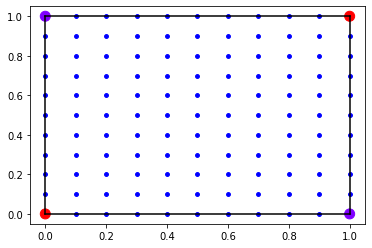

In [3]:
n = 11
x_left_horizontal = np.zeros(200 + 1)
y_left_horizontal = np.linspace(0, 1, 200 + 1)
plt.plot(x_left_horizontal,y_left_horizontal, c = 'black')

x_right_horizontal = np.ones(200 + 1)
y_right_horizontal = np.linspace(0, 1, 200 + 1)
plt.plot(x_right_horizontal,y_right_horizontal, c = 'black')

x_upper_vertical = np.linspace(0, 1, 200 + 1)
y_upper_vertical = np.ones(200 + 1)
plt.plot(x_upper_vertical,y_upper_vertical, c = 'black')

x_lower_vertical = np.linspace(0, 1, 200 + 1)
y_lower_vertical = np.zeros(200 + 1)
plt.plot(x_lower_vertical,y_lower_vertical, c = 'black')


xv, yv = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
X = np.array([xv.flatten(), yv.flatten()]).T
plt.scatter(X[:, 0], X[:, 1], c = 'blue', s = 15)

train_ind = np.array([find_occurence(X, np.array([0, 1])), find_occurence(X, np.array([1, 0])), find_occurence(X, np.array([0, 0])), find_occurence(X, np.array([1, 1])) ])
train_labels = np.array([0, 0, 1, 1])

plt.scatter(X[train_ind, 0], X[train_ind, 1], c = train_labels, s = 100,  cmap = 'rainbow')

plt.show()

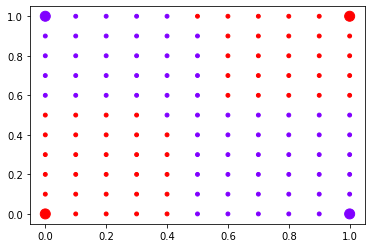

In [4]:
try:
    models
except:
    models = {}
else:
    pass

W = gl.weightmatrix.knn(X,5).toarray()

models['GraphLearn'] = gl.ssl.poisson(W, solver='gradient_descent')
pred_labels = models['GraphLearn'].fit_predict(train_ind, train_labels)

plt.scatter(X[:, 0], X[:, 1], c = pred_labels, s = 15,  cmap = 'rainbow')
plt.scatter(X[train_ind, 0], X[train_ind, 1], c = train_labels, s = 100,  cmap = 'rainbow')

########### Gradient Descent (w/ Jacobian) for p = 4
Energy = -12.92
Discrepancies = 5
Runtime = 1.38 min
########### Gradient Descent (w/ Jacobian) for p = 8
Energy = -13.00
Discrepancies = 7
Runtime = 4.03 min
########### Gradient Descent (w/ Jacobian) for p = 10
Energy = -12.93
Discrepancies = 7
Runtime = 4.05 min
########### Gradient Descent (w/ Jacobian) for p = 12
Energy = -12.89
Discrepancies = 8
Runtime = 4.05 min


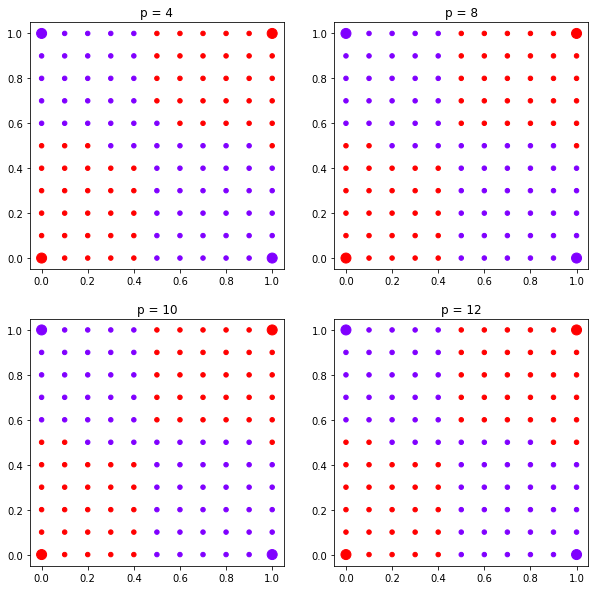

In [5]:
try:
    models
except:
    models = {}
else:
    pass

p_vals = [4, 8, 10, 12]
fig, ax = plt.subplots(len(p_vals)//2 , 2, figsize = (10, 10)) 

model = gl.ssl.poisson(W, solver='gradient_descent')
my_u = model.fit(train_ind, train_labels)
euclidean_labels = euclidean_basis(train_labels, 2)

i = 0
for axis in ax.flat:
    start_time = time.time()
    p = p_vals[i]
    models[p] = ppoisson(W, p)

    my_u = models[p].fit(train_ind, euclidean_labels, start = my_u.flatten())
    my_pred_labels = models[p].predict()

    energy = np.around(penergy(my_u.flatten(), W, train_ind, euclidean_labels, p), 2)
    discrepancies = np.count_nonzero(my_pred_labels - pred_labels)
    end_time = time.time()
    minutes = (end_time - start_time)/60

    i += 1

    info_str = f"########### Gradient Descent (w/ Jacobian) for p = {p}\n"\
                f"Energy = {energy:.2f}\n"\
                f"Discrepancies = {discrepancies}\n"\
                f"Runtime = {minutes:.2f} min"

    print(info_str)
    
    axis.scatter(X[:, 0], X[:, 1], c = my_pred_labels, s = 20,  cmap = 'rainbow')
    axis.scatter(X[train_ind, 0], X[train_ind, 1], c = train_labels, s = 100,  cmap = 'rainbow')
    axis.set_title(f"p = {p}")

########### Gradient Descent (w/ Jacobian) for p = 14
Energy = -12.86
Discrepancies = 8
Runtime = 4.16 min
########### Gradient Descent (w/ Jacobian) for p = 20
Energy = -12.81
Discrepancies = 8
Runtime = 4.09 min
########### Gradient Descent (w/ Jacobian) for p = 25
Energy = -12.78
Discrepancies = 8
Runtime = 4.10 min
########### Gradient Descent (w/ Jacobian) for p = 30
Energy = -12.77
Discrepancies = 8
Runtime = 4.10 min


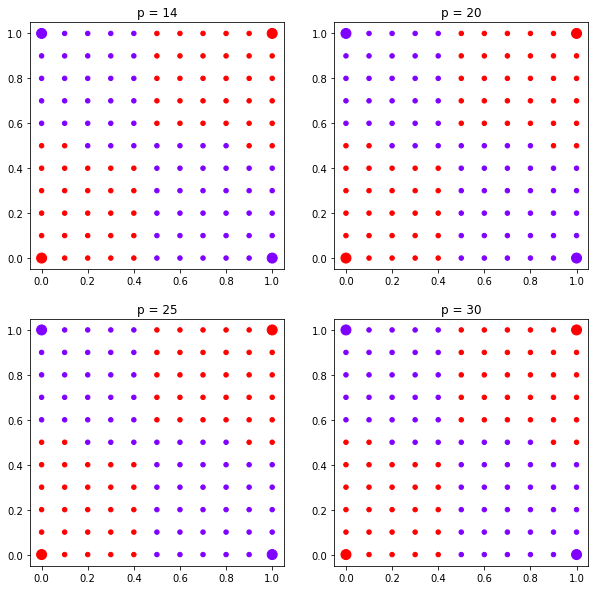

In [6]:
try:
    models
except:
    models = {}
else:
    pass

p_vals = [14, 20, 25, 30]
fig, ax = plt.subplots(len(p_vals)//2 , 2, figsize = (10, 10)) 

i = 0
for axis in ax.flat:
    start_time = time.time()
    p = p_vals[i]
    models[p] = ppoisson(W, p)

    my_u = models[p].fit(train_ind, euclidean_labels, start = my_u.flatten())
    my_pred_labels = models[p].predict()

    energy = np.around(penergy(my_u.flatten(), W, train_ind, euclidean_labels, p), 2)
    discrepancies = np.count_nonzero(my_pred_labels - pred_labels)
    end_time = time.time()
    minutes = (end_time - start_time)/60

    i += 1

    info_str = f"########### Gradient Descent (w/ Jacobian) for p = {p}\n"\
                f"Energy = {energy:.2f}\n"\
                f"Discrepancies = {discrepancies}\n"\
                f"Runtime = {minutes:.2f} min"

    print(info_str)
    
    axis.scatter(X[:, 0], X[:, 1], c = my_pred_labels, s = 20,  cmap = 'rainbow')
    axis.scatter(X[train_ind, 0], X[train_ind, 1], c = train_labels, s = 100,  cmap = 'rainbow')
    axis.set_title(f"p = {p}")

########### Gradient Descent (w/ Jacobian) for p = 30
Energy = -12.77
Discrepancies = 8
Runtime = 4.12 min
########### Gradient Descent (w/ Jacobian) for p = 50
Energy = -12.75
Discrepancies = 8
Runtime = 4.25 min
########### Gradient Descent (w/ Jacobian) for p = 75
Energy = -12.74
Discrepancies = 8
Runtime = 4.04 min
########### Gradient Descent (w/ Jacobian) for p = 100
Energy = -12.71
Discrepancies = 8
Runtime = 4.01 min


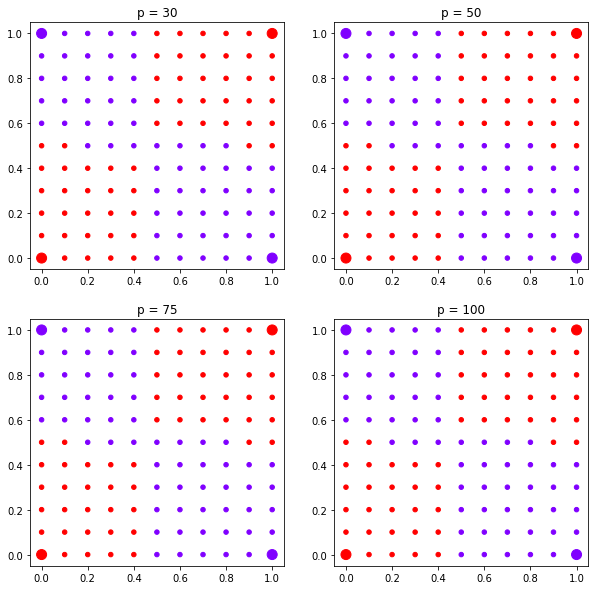

In [12]:
try:
    models
except:
    models = {}
else:
    pass

p_vals = [30, 50, 75, 100]
fig, ax = plt.subplots(len(p_vals)//2 , 2, figsize = (10, 10)) 

i = 0
for axis in ax.flat:
    start_time = time.time()
    p = p_vals[i]
    models[p] = ppoisson(W, p)

    my_u = models[p].fit(train_ind, euclidean_labels, start = my_u.flatten())
    my_pred_labels = models[p].predict()

    energy = np.around(penergy(my_u.flatten(), W, train_ind, euclidean_labels, p), 2)
    discrepancies = np.count_nonzero(my_pred_labels - pred_labels)
    end_time = time.time()
    minutes = (end_time - start_time)/60

    i += 1

    info_str = f"########### Gradient Descent (w/ Jacobian) for p = {p}\n"\
                f"Energy = {energy:.2f}\n"\
                f"Discrepancies = {discrepancies}\n"\
                f"Runtime = {minutes:.2f} min"

    print(info_str)
    
    axis.scatter(X[:, 0], X[:, 1], c = my_pred_labels, s = 20,  cmap = 'rainbow')
    axis.scatter(X[train_ind, 0], X[train_ind, 1], c = train_labels, s = 100,  cmap = 'rainbow')
    axis.set_title(f"p = {p}")

In [14]:
print(np.linalg.norm(models[14].solution - models[20].solution))
print(np.linalg.norm(models[20].solution - models[25].solution))
print(np.linalg.norm(models[25].solution - models[30].solution))
print(np.linalg.norm(models[30].solution - models[50].solution))
print(np.linalg.norm(models[50].solution - models[75].solution))
print(np.linalg.norm(models[75].solution - models[100].solution))

0.8312818496879244
0.36646087683827916
0.2387545559734004
0.4152019676055193
0.17085873297732693
5.844459781104776e-09


# Save models

In [15]:
#save_models(models)

# Load models

In [8]:
#models = load_models()